## Node2Vec Implementation

<p> Node2Vec is based on the same architecture of DeepWalk , keeping the : `Random Walks` and `Word2Vec` elements, by adding bias to the Randoms walks by :
<li>Promoting nodes that are not connected to the previous one (DFS)</li>
<li>Promoting nodes that are similar to the previous one (similar to BFS)</li>

</p>

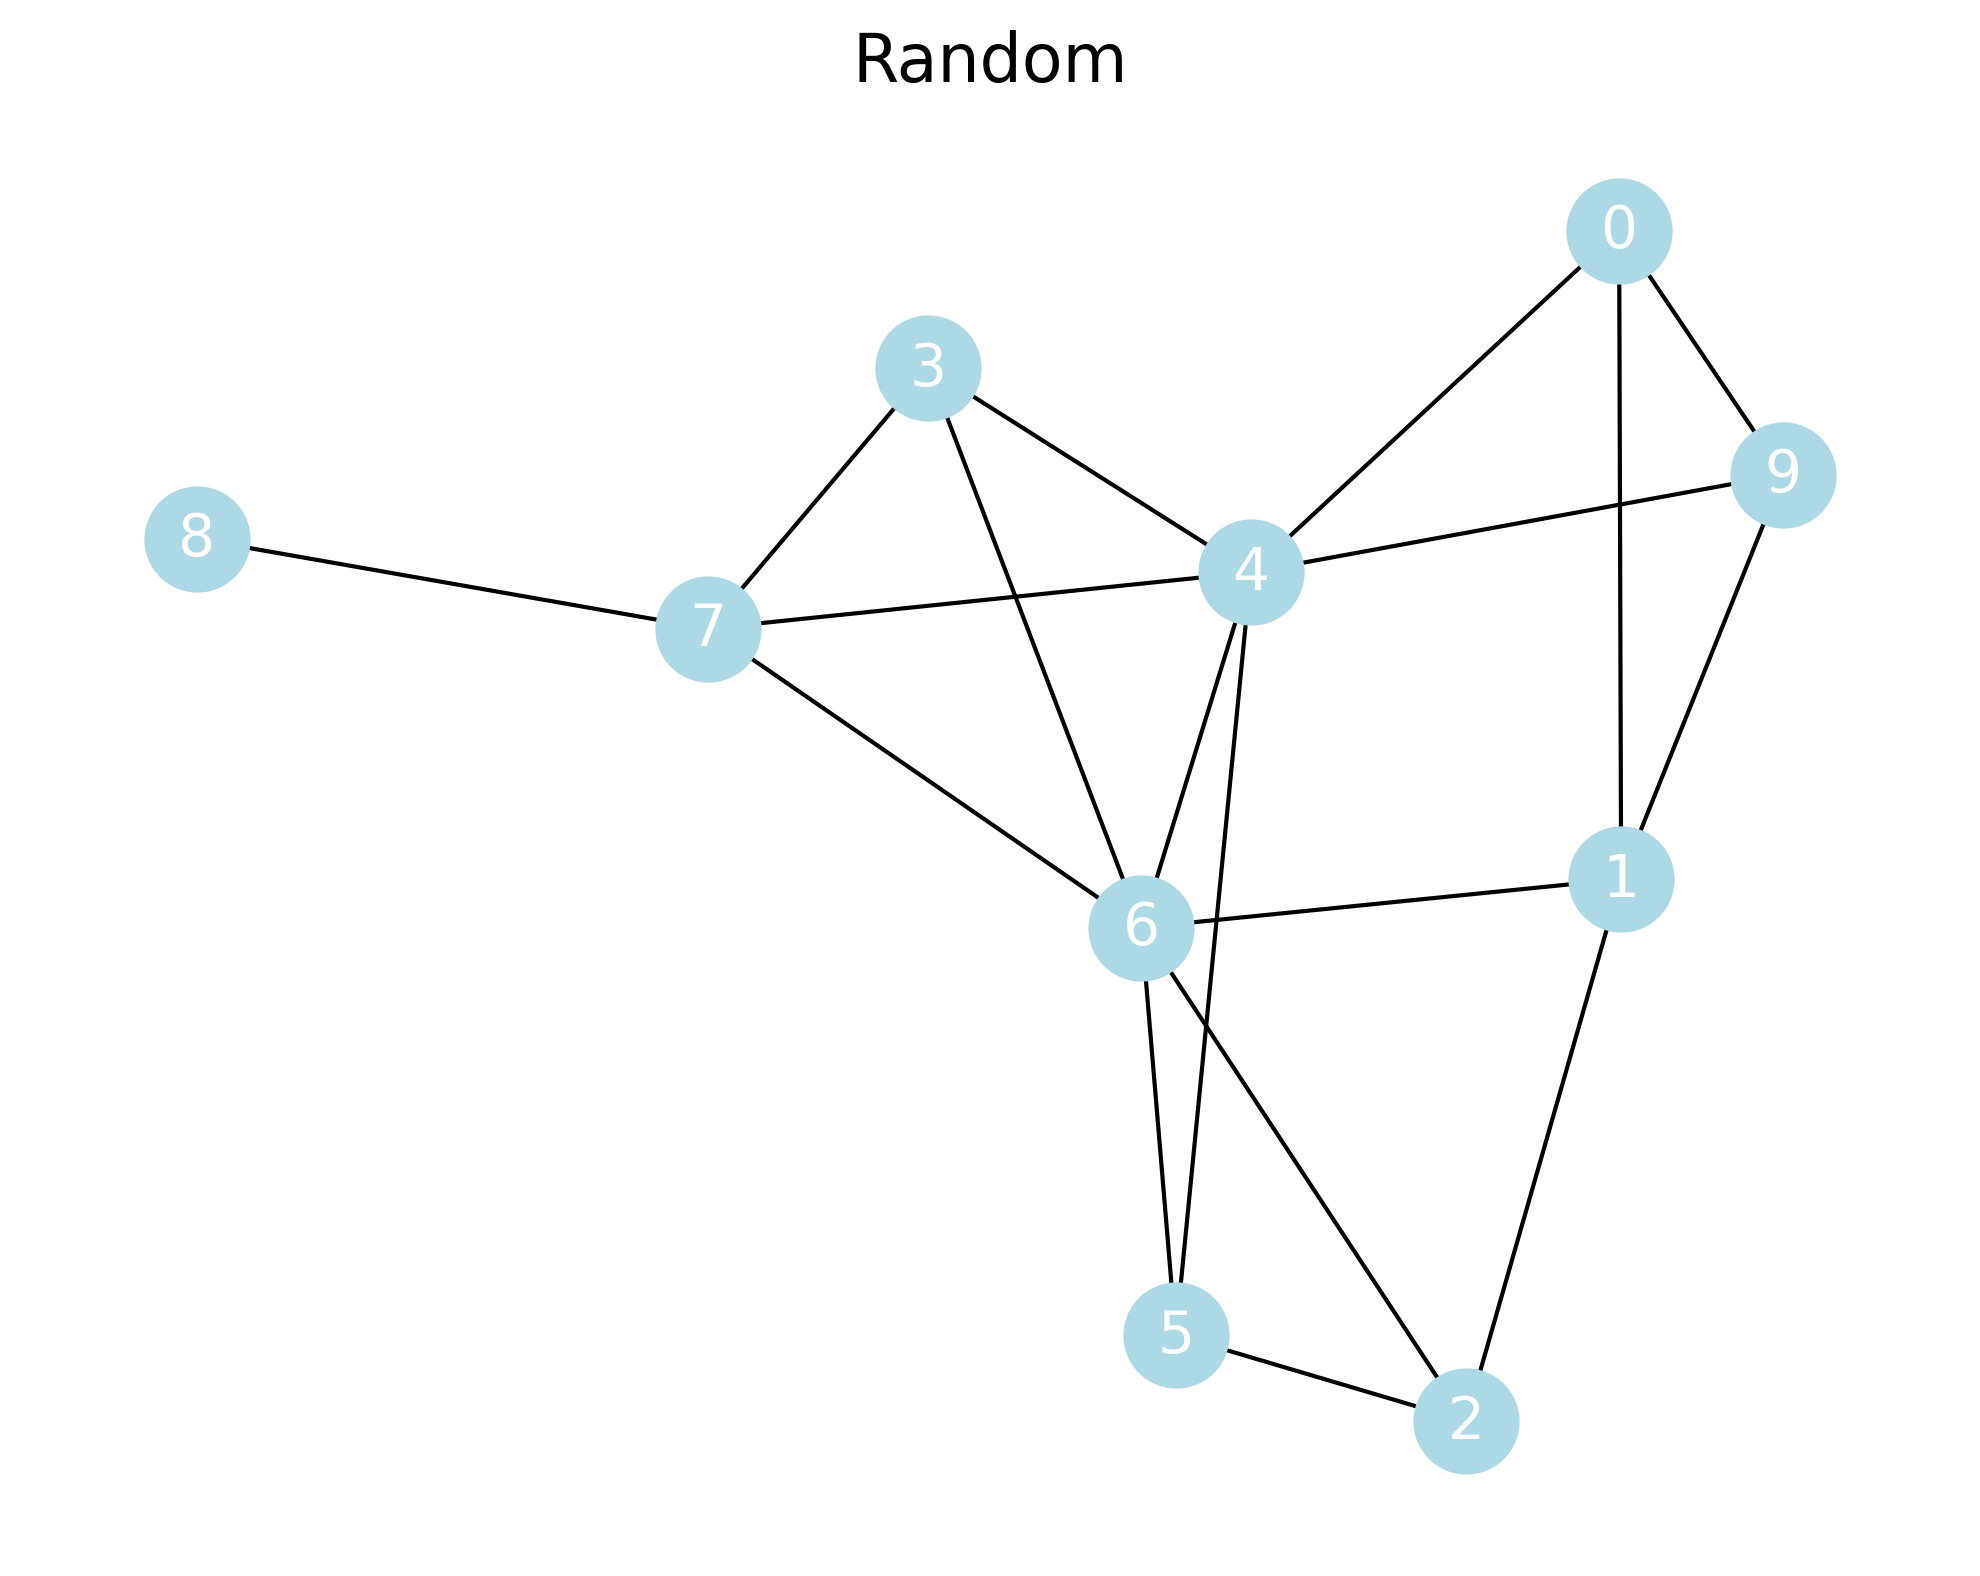

In [1]:
### Let's create a random Graph ###

import networkx as nx
import random
random.seed(0)
import numpy as np
import matplotlib.pyplot as plt


G = nx.erdos_renyi_graph(10, 0.3, seed = 1, directed = False)

def draw_graph(G):
    pos = nx.spring_layout(G, seed = 0)
    plt.figure(dpi = 300)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=600, font_size=14, font_color='white', edge_color='black')
    plt.title("Random", fontsize=16)
    plt.show()
draw_graph(G)


In [2]:
### Next Node function ###
def next_node(previous_node, current_node, p, q):
    """
    This function takes a previous node and returns the next node in the graph
    :param previous_node: The previous node
    :param current_node: The graph
    :p: The Prpbability of going back to the previous node
        High p → Less likely to go back.
        Low p → More likely to go back.
    :q: The Probability of going to the next node
        High q → Less likely to go to the next node.
        Low q → More likely to go to the next node.
    :return: The next node
    """
    neighbors = list(G.neighbors(current_node))
    if not neighbors:
        return None  # or handle accordingly

    alphas = []

    ### Let's calculate the appropriate alphas ###
    """
    calculate the alphas for each neighbor of the current node.
    1/p if the neighbor is the previous node, 1, if this one in connected to 
    the previous node , and 1/q, otherwise"
    """
    for neighbor in neighbors:
        if neighbor == previous_node :
            alpha = 1/p
        elif previous_node is not None and G.has_edge(neighbor, previous_node):
                alpha = 1
        else:
                alpha = 1/q
        alphas.append(alpha)  
    ### Let's calculate the probabilities ###
    probs = [alpha/sum(alphas) for alpha in alphas]

    ### Let's randomly choose the next node  based on the calculated prob ###
    next = np.random.choice(neighbors, size =1, p = probs)[0]

    return next

In [3]:
### Define the random walk function ###

def random_walk(start_node, num_steps, p, q):
    walk = [start_node]

    for i in range(num_steps):
        current_node = walk[-1]
        previous_node = walk[-2] if len(walk) > 1 else None
        next = next_node(previous_node, current_node, p, q)
        walk.append(next)
    return [str (x) for x in walk]


In [4]:
random_walk(0, 8, p=1, q= 1)

['0', '4', '3', '7', '4', '5', '6', '4', '7']

In [5]:
### Let's bias the random walk ###
random_walk ( 0, 8, p= 1, q= 10)

['0', '9', '4', '9', '0', '9', '0', '4', '0']

<h5>Adjusting the value of p =10, strongly reduces the chance to go back to the previous node , because the probability is low </h5>

In [6]:
### Let's bias the random walk ###
random_walk ( 0, 8, p= 10, q= 1)

['0', '4', '5', '2', '1', '0', '4', '3', '7']

<h3> Now Let's Implement Node2Vec Using the KarateClub dataset</h3>

In [7]:
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

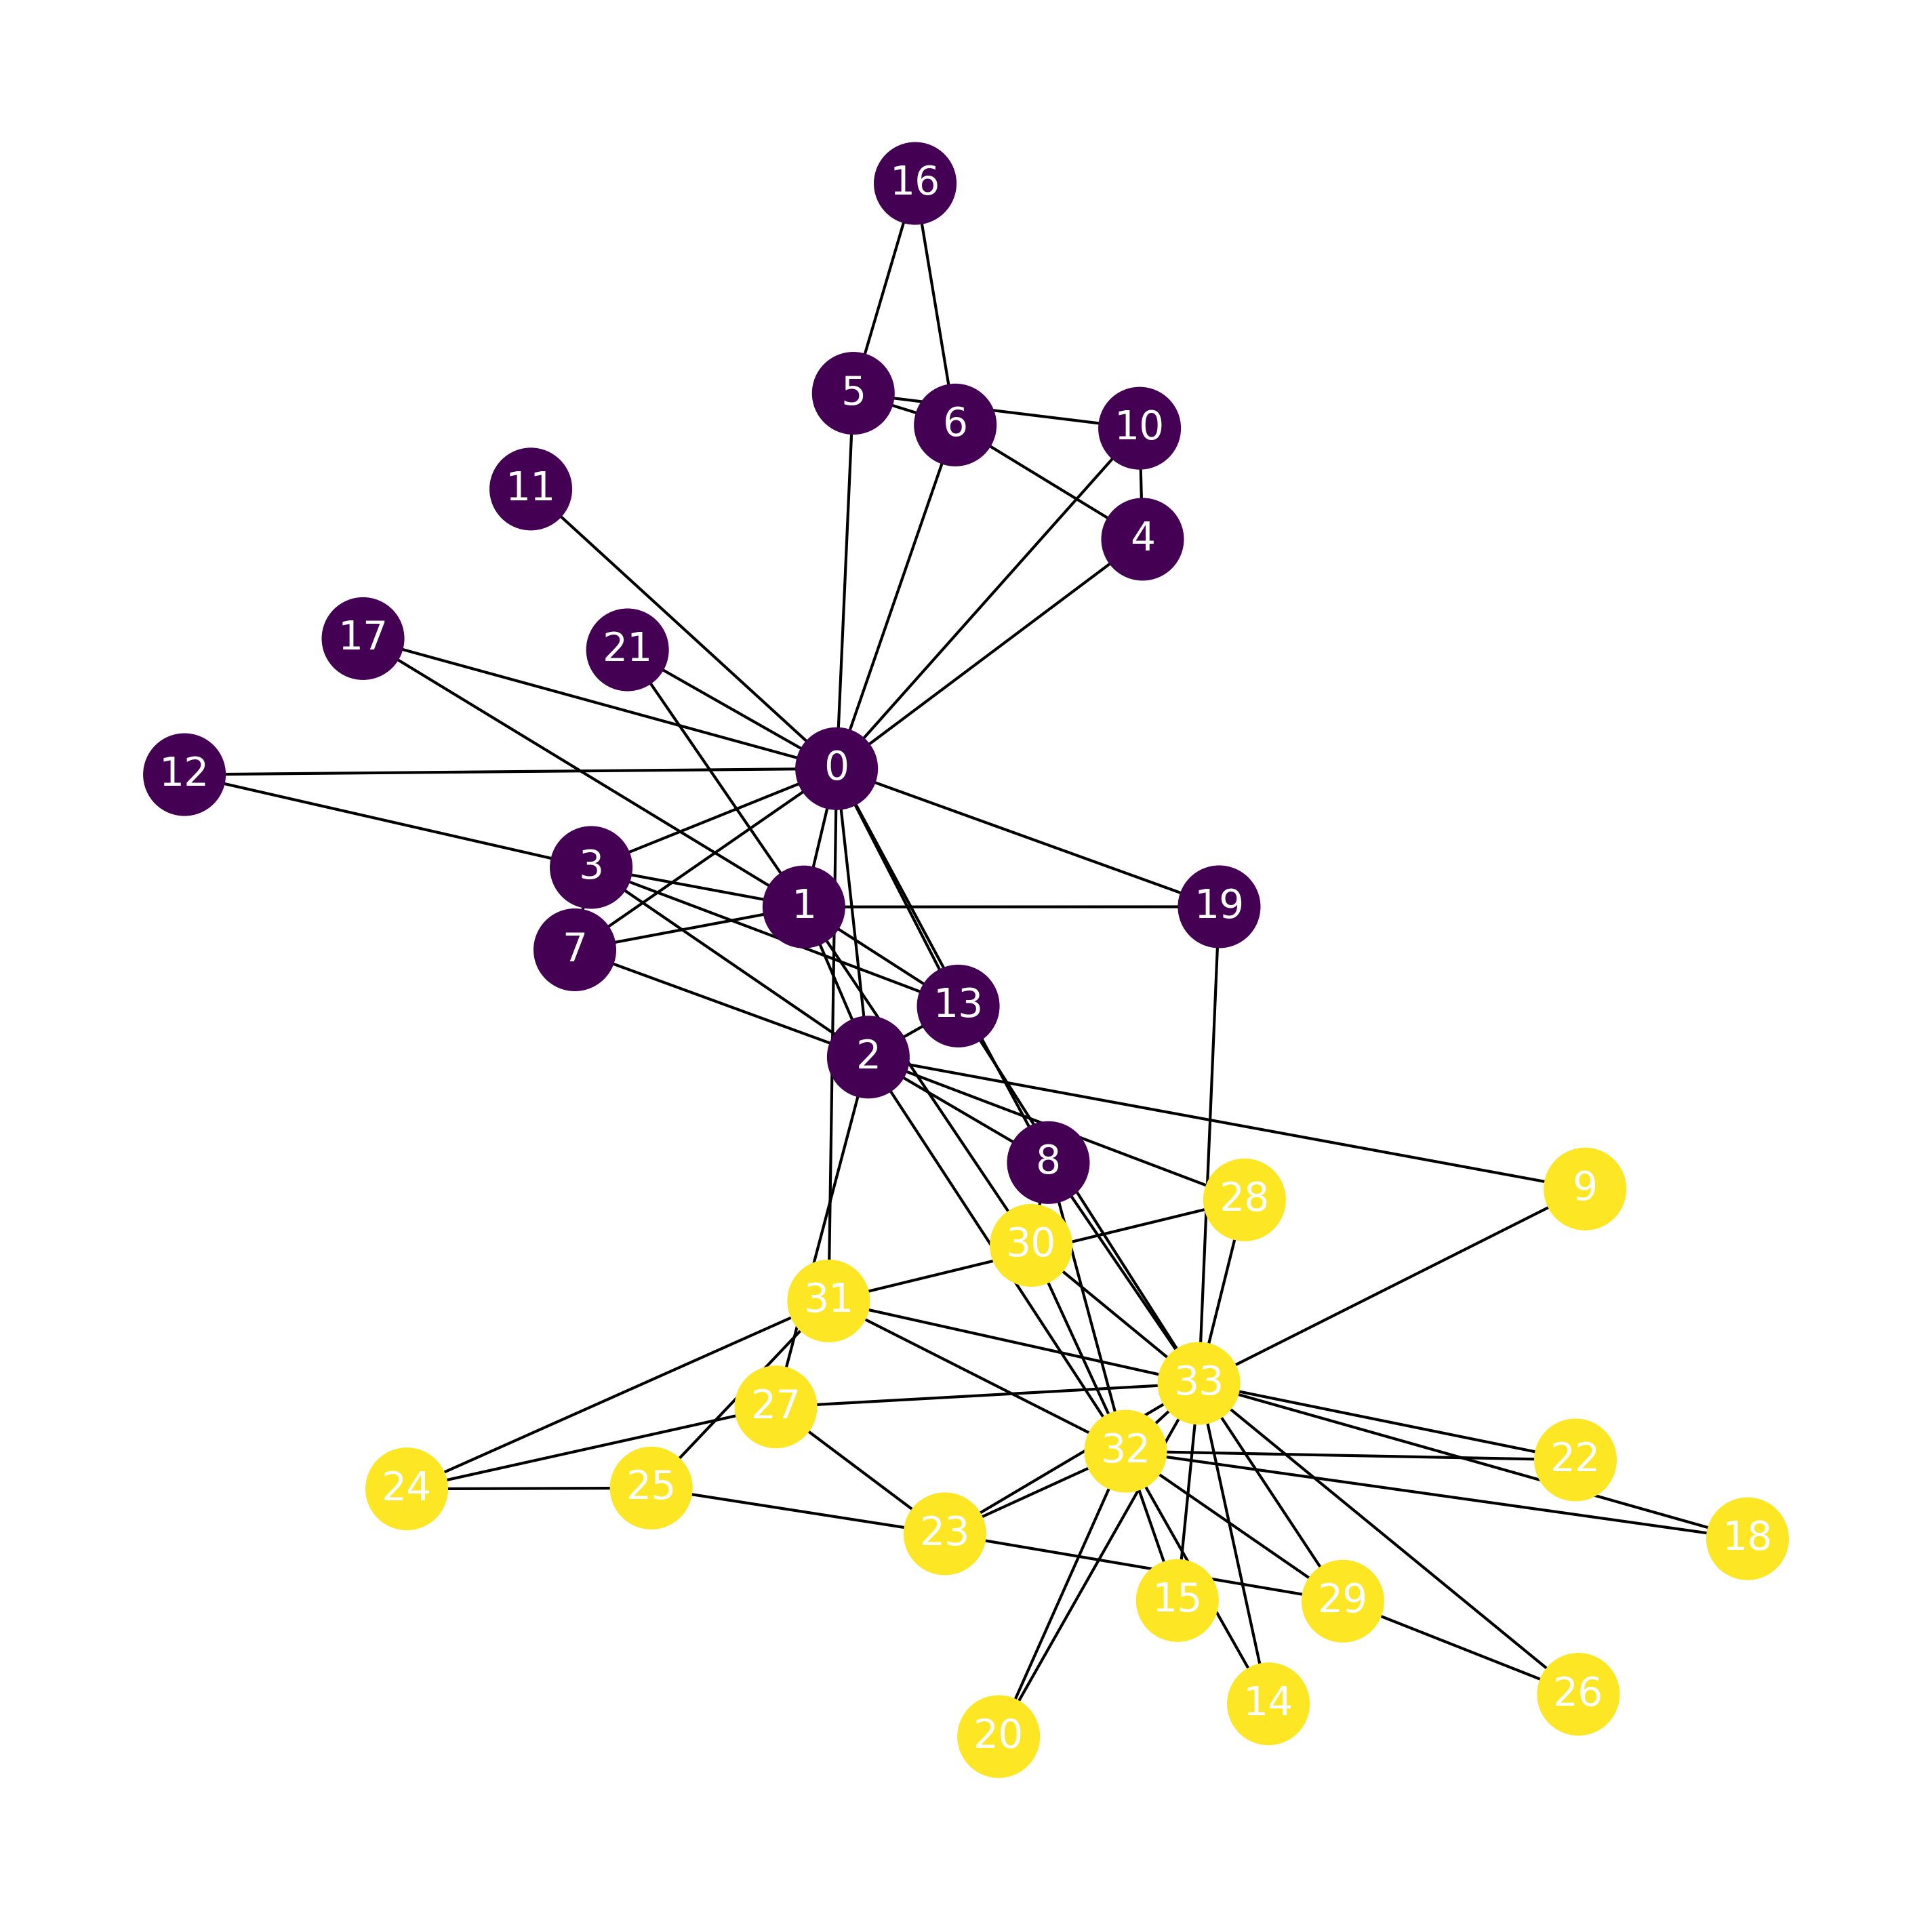

In [8]:
### Load the Dataset ###
G = nx.karate_club_graph()
### Transform the nodel labels into numerical values ###
labels = []
for node in G.nodes():
    # print(G.nodes[node])  
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)
    # print(f"Node {node} has label {label} and is represented as {labels[-1]}")

### Let's plot the graph with the labels ###
plt.figure(figsize =(12,12), dpi = 300)
plt.axis ('off')
nx.draw(G, 
pos = nx.spring_layout(G, seed = 0),
with_labels=True, node_color=labels,
node_size=800, 
font_size=14,
font_color='white',
edge_color='black')

In [9]:
### Using the random walk funtion ###
walks = []
for node in G.nodes():
    for _ in range(80):
        walk = random_walk(node, 10, p=3, q=2) # We can change the parameters
        walks.append(walk)

In [10]:
print(walks[:3])

[['0', '31', '24', '25', '23', '32', '2', '27', '2', '3', '0'], ['0', '1', '0', '11', '0', '11', '0', '8', '30', '33', '8'], ['0', '4', '0', '17', '1', '21', '0', '7', '3', '2', '13']]


In [11]:
### Create an instance of Word2Vec(skip-gram) using Hierarchical softmax ###
node2vec = Word2Vec(sentences=walks, 
                    vector_size=128,
                    window=5,
                    min_count=1,
                    sg=1, # skip-gram
                    hs=1, # Hierarchical softmax
                    workers=4,
                    seed = 0)

In [12]:
### Train the model ###
node2vec.train(walks, total_examples=node2vec.corpus_count, epochs=50, report_delay=1)

(310924, 1496000)

In [13]:
# print('Word embedding =')
# print(node2vec.wv[0])

In [14]:
### Let's create the train and test masks ###
train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
train_mask_str = [str(x) for x in train_mask]

test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]
test_mask_str = [str(x) for x in test_mask]

labels = np.array(labels)

In [15]:
### Let's train the Random Forest Classifier ###
clf = RandomForestClassifier( random_state=0)
clf.fit(node2vec.wv[train_mask_str], labels[train_mask])

### Let's predict the labels ###
predictions = clf.predict(node2vec.wv[test_mask_str])
# print(predictions)
### Let's calculate the accuracy ###
accuracy = accuracy_score(labels[test_mask], predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.95


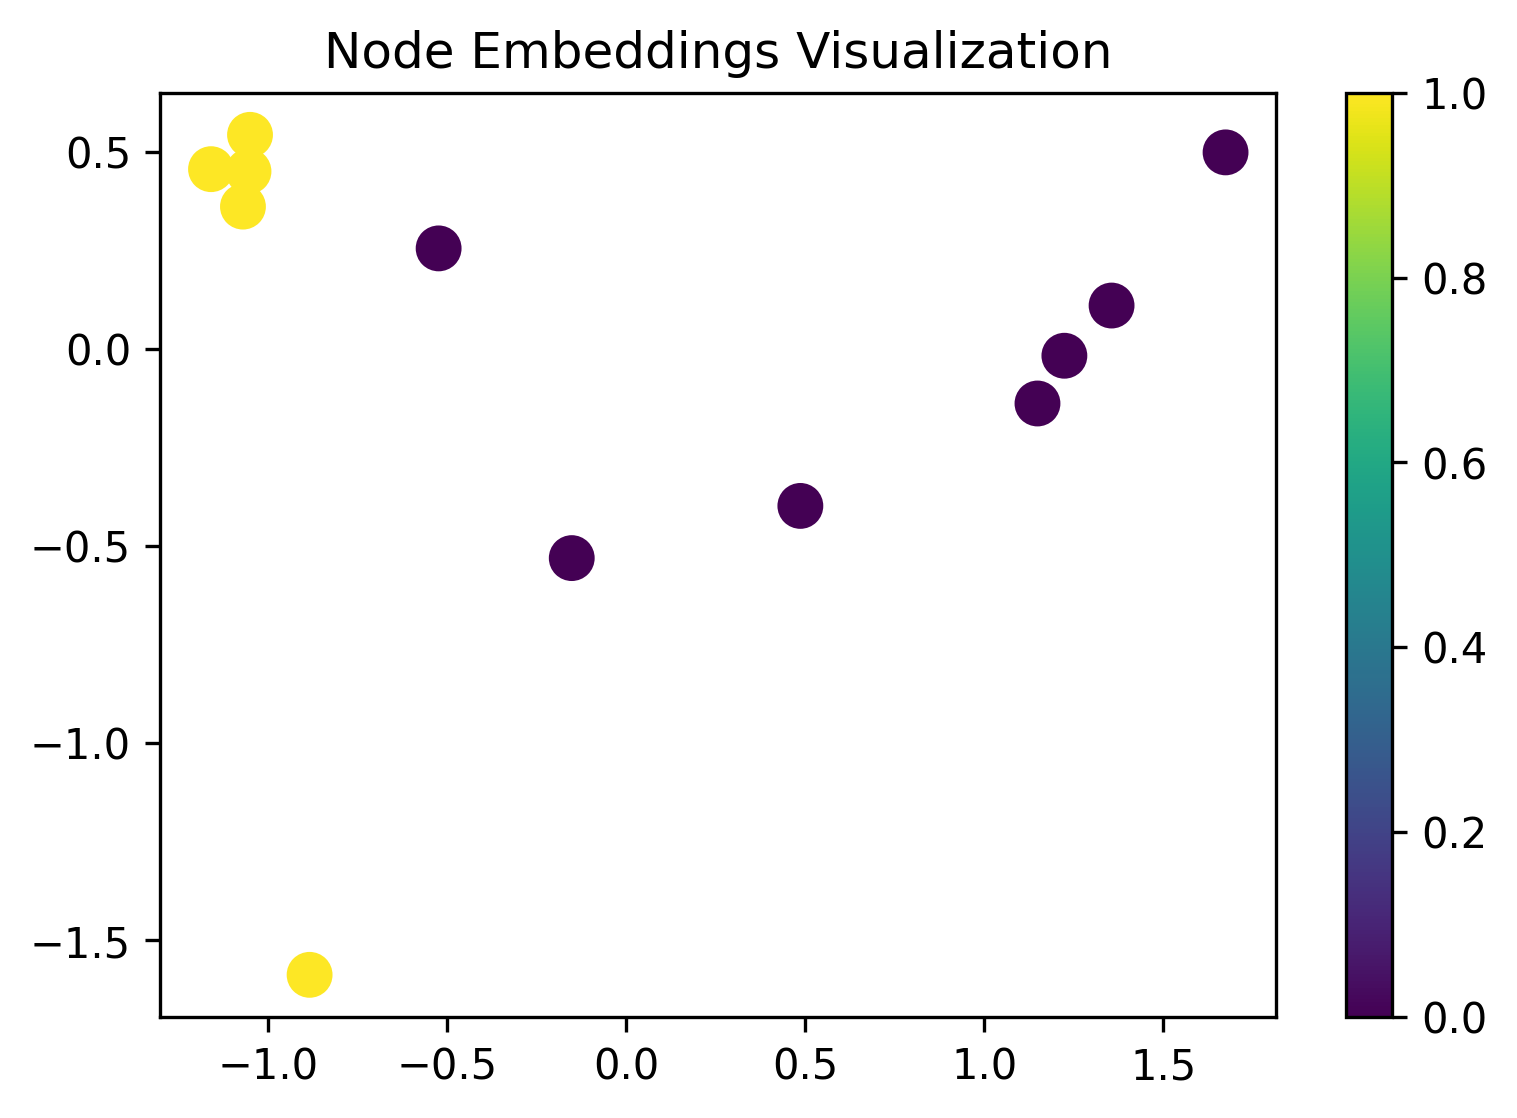

In [16]:
### Let's visualize the embeddings ###
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def plot_embeddings(embeddings, labels):
    pca = PCA(n_components=2)
    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = pca.fit_transform(embeddings)
    plt.figure(figsize=(6, 4), dpi=300)
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', s=100)
    plt.title("Node Embeddings Visualization")
    plt.colorbar()
    plt.show()
plot_embeddings(node2vec.wv[train_mask_str], labels[train_mask])
# plot_embeddings(node2vec.wv[test_mask_str], labels[test_mask])